In [2]:
import numpy as np
import pandas as pd
import time 
import re

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
english_stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# machine learning

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn.metrics import classification_report

import seaborn as sns
sns.set(style ='whitegrid')
pd.set_option('display.max_columns',None)

In [3]:
df_data=pd.read_csv('twitter_training.csv',header=None)
df_data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
#Load test data
df_test=pd.read_csv('twitter_validation.csv',header=None)
df_test.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [5]:
#Function to rename the columns to get a better sense of data
def rename_dataframe(df):
    df.rename(columns= {0:'Tweet_ID',1:'Topic',2:'Sentiment',3:'Tweet'},inplace=True)

In [6]:
#Rename train data
rename_dataframe(df_data)
df_data.head()

,Tweet_ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
#Rename test data
rename_dataframe(df_test)
df_test.head()

,Tweet_ID,Topic,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# EDA

In [8]:
#shape of data
print('Train data shape: ',df_data.shape) 
print('Test data shape: ',df_test.shape)

Train data shape:  (74682, 4)
Test data shape:  (1000, 4)


In [9]:
#percentage of missing data
(df_data.isnull().sum()/len(df_data))*100

Tweet_ID     0.000000
Topic        0.000000
Sentiment    0.000000
Tweet        0.918561
dtype: float64

In [10]:
#As only 0.91% of data in Tweet features are null we will drop them
df_data.dropna(axis=0,inplace=True)

In [11]:
#check percentage of missing data after dropping missing features
(df_data.isnull().sum()/len(df_data))*100

Tweet_ID     0.0
Topic        0.0
Sentiment    0.0
Tweet        0.0
dtype: float64

In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   73996 non-null  int64 
 1   Topic      73996 non-null  object
 2   Sentiment  73996 non-null  object
 3   Tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [13]:
print('Distinct Values: \n')
col=['Topic','Sentiment']
for i in col:
    print(i,'->')
    print(df_data[i].value_counts())
    print('\n')

Distinct Values: 

Topic ->
MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283
Border

In [15]:
import matplotlib.pyplot as plt

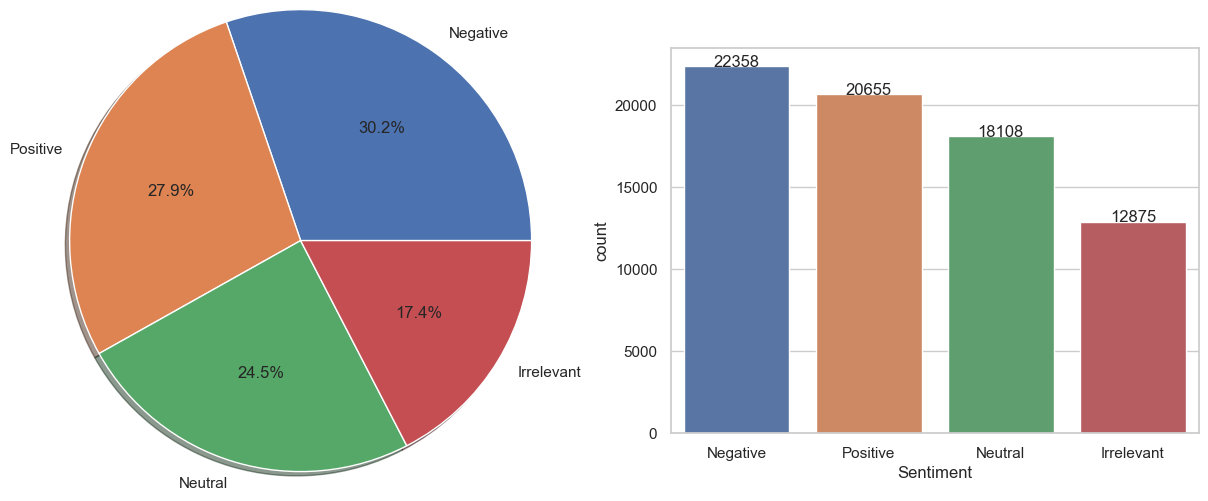

In [16]:
#Visualizing Sentiment feature - Target feature
plt.figure(figsize=(15,5))

#plot pie chart
plt.subplot(1,2,1)
label = df_data['Sentiment'].value_counts().index
label_count = df_data['Sentiment'].value_counts().values
plt.pie(data=df_data, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1.5)

#plot countplot
plt.subplot(1,2,2)
ax = sns.countplot(x='Sentiment', data=df_data, order=label)
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2),
    y=height+0.2,ha='center',s='{:.0f}'.format(height))
plt.show()

In [17]:
#Get the count of words in each tweet
df_data['Tweet_word_count']=df_data['Tweet'].apply(lambda x: len(x.split()))

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_532\2131348791.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_data['Tweet_word_count'])


<AxesSubplot:ylabel='Density'>

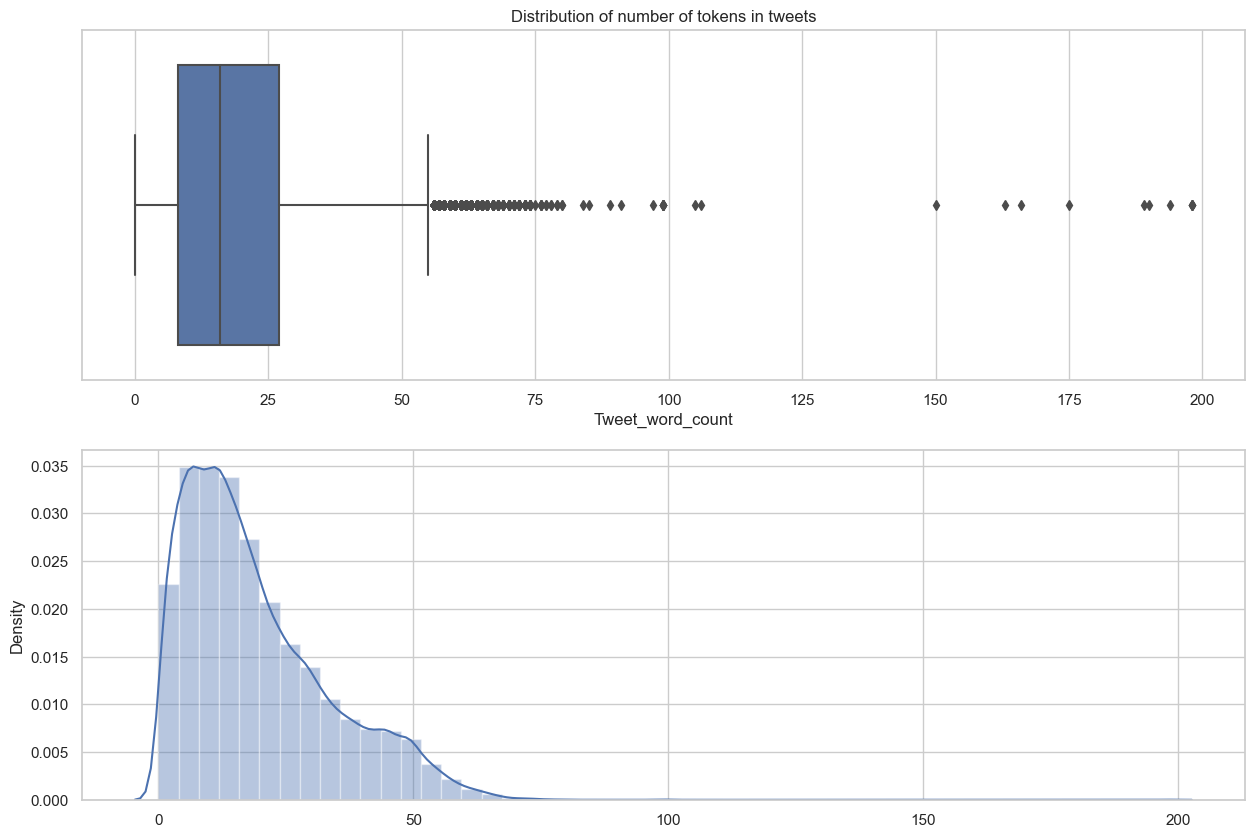

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.boxplot(x=df_data['Tweet_word_count'])
plt.title(('Distribution of number of tokens in tweets'))

plt.subplot(2,1,2)
sns.distplot(x=df_data['Tweet_word_count'])

In [19]:
#Extreme outliers
extreme_outliers = df_data['Tweet'][df_data['Tweet_word_count']>125]

for i in extreme_outliers.index:
    print(i,'Tweet Sentiment: ',df_data['Sentiment'][i])
    print(extreme_outliers[i])
    print('\n')

1826 Tweet Sentiment:  Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


8546 Tweet Sentiment:  Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E


10454 Tweet Sentiment:  Positive
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

In [20]:
#Get count of characters in each tweet excluding the whitespaces
df_data['Tweet_char_count']=df_data['Tweet'].apply(lambda x: len(x)-x.count(' '))

C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_532\4176880891.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_data['Tweet_char_count'])


<AxesSubplot:ylabel='Density'>

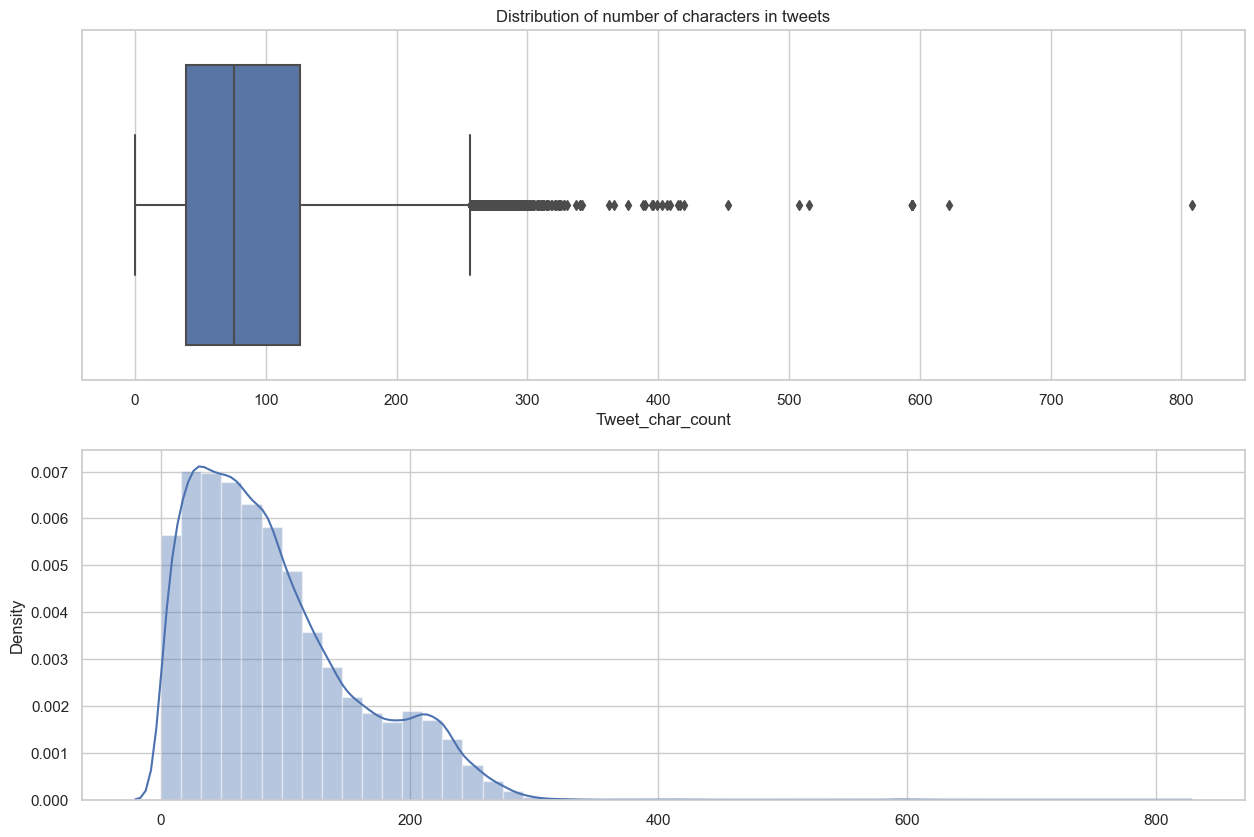

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.boxplot(x=df_data['Tweet_char_count'])
plt.title(('Distribution of number of characters in tweets'))

plt.subplot(2,1,2)
sns.distplot(x=df_data['Tweet_char_count'])

# Data preprocessing

Remove user mentions from the tweets

In [22]:

#'I want to join @google' will become 'I want to join'
df_data['Tweet_clean']=df_data['Tweet'].apply(lambda x: re.sub(r'@[A-Za-z0-9]+','',x))

Remove hashtags from the tweets

In [23]:

#'My new house #goals' will become 'My new house'
df_data['Tweet_clean']=df_data['Tweet_clean'].apply(lambda x: re.sub('#','',x))

Remove contractions

In [24]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [25]:
df_data['Tweet_clean']=df_data['Tweet_clean'].apply(lambda x: ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in x.split(" ")]))

Remove links/urls from the tweets

In [26]:
def txt_conversion(sentence):
    #Getting only the letters from the tweets
    sentence=re.sub(r'[^a-zA-Z ]','',sentence)
    #Converting them to lowercase
    sentence=sentence.lower()
    #split based on space to remove multiple spaces
    words=sentence.split()
    #combining to form sentence
    return (" ".join(words)).strip()

In [27]:
df_data['Tweet_clean']=df_data['Tweet_clean'].apply(lambda x: txt_conversion(x))

Removing stop-words and cpnverting words to lemma

In [28]:
#Removing stop-words and cpnverting words to lemma
#Stop words are the most commonly used words in a language (such as “the”, “a”, “an”, “in”)
#Example After lemmatization words like multiplication, multiplicative will become multiple
def stop_wrds_lemma_convert(sentence):
    tokens = [w for w in sentence.split() if not w in stop_words] #stopwords removal
    newString=''
    for i in tokens:                                                 
        newString=newString+lemmatizer.lemmatize(i)+' '    #converting words to lemma                               
    return newString.strip()   

In [29]:
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words


In [30]:
df_data['Tweet_clean']=remove_stop_words(df_data['Tweet_clean'])

In [31]:
#Drop columns that are not required
df_data.drop(columns=['Tweet_ID','Tweet'],axis=0,inplace=True)

In [32]:
df_data.dropna(axis=0,how='any',inplace=True)

In [33]:
from wordcloud import WordCloud

(-0.5, 799.5, 499.5, -0.5)

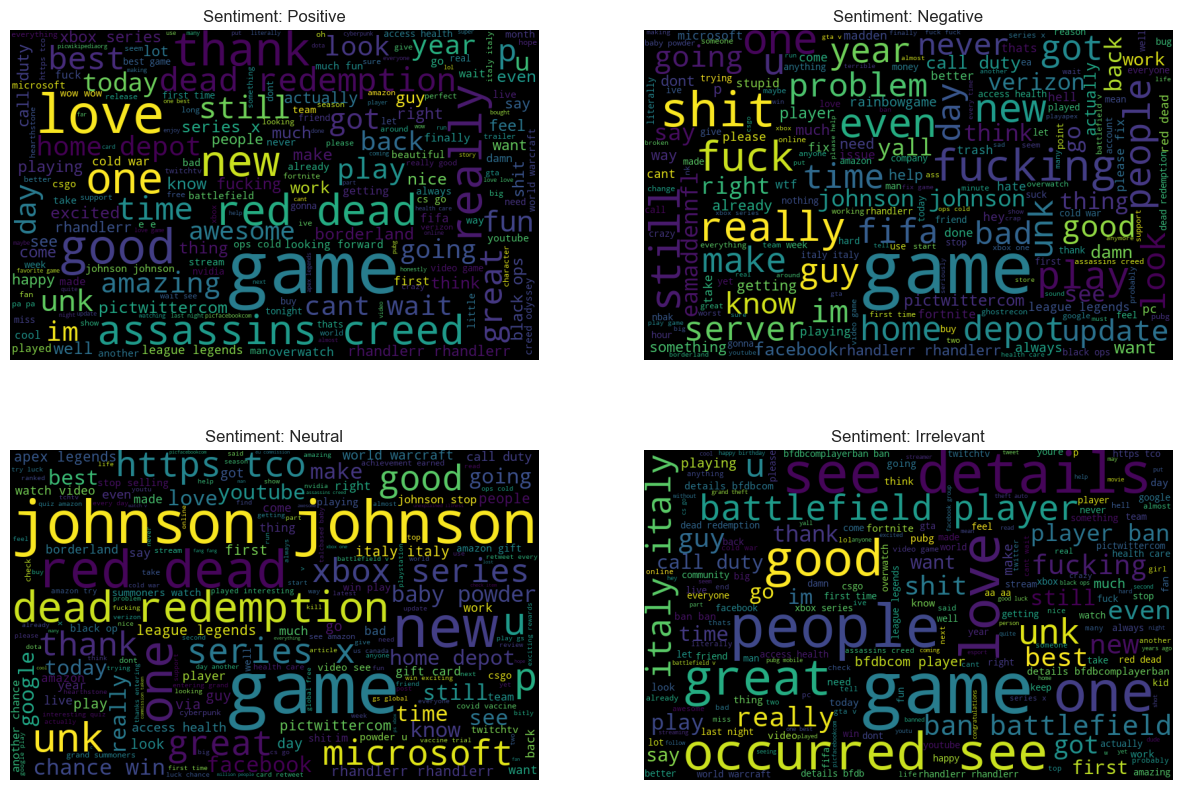

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
all_words=' '.join([text for text in df_data[df_data['Sentiment']=='Positive']['Tweet_clean']])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.title('Sentiment: Positive')
plt.imshow(wordcloud)
plt.axis('off')

plt.subplot(2,2,2)
all_words=' '.join([text for text in df_data[df_data['Sentiment']=='Negative']['Tweet_clean']])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.title('Sentiment: Negative')
plt.imshow(wordcloud)
plt.axis('off')

plt.subplot(2,2,3)
all_words=' '.join([text for text in df_data[df_data['Sentiment']=='Neutral']['Tweet_clean']])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.title('Sentiment: Neutral')
plt.imshow(wordcloud)
plt.axis('off')

plt.subplot(2,2,4)
all_words=' '.join([text for text in df_data[df_data['Sentiment']=='Irrelevant']['Tweet_clean']])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.title('Sentiment: Irrelevant')
plt.imshow(wordcloud)
plt.axis('off')

# Model Building

In [35]:
#Seperate dependent and independent features
X=df_data.loc[:,df_data.columns!='Sentiment']
y=df_data['Sentiment']

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (51797, 4) (51797,)
Test (22199, 4) (22199,)


In [36]:
#TF-IDF
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),min_df=10,max_features=10000) 
#Train on train data
features_train= vectorizer.fit_transform(X_train['Tweet_clean'])
#Apply on test data
features_valid= vectorizer.transform(X_valid['Tweet_clean'])
#check shape
features_train.shape, features_valid.shape

((51797, 7948), (22199, 7948))

In [37]:
#evaluation metrics
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score

In [38]:
#Function to fit and apply a model
def model_apply(model):
    #train the model
    model.fit(features_train,y_train)
    #make predictions
    pred=model.predict(features_valid)
    #model evaluation
    print(model)
    print('Accuracy score: ',accuracy_score(pred,y_valid))
    print('Weighted F1 score: ',f1_score(y_pred=pred,y_true=y_valid,average='weighted'))
    print('Confusion Matrix: \n',confusion_matrix(pred,y_valid))

In [39]:
#Multinomail Naive Bayes
nb=MultinomialNB()
model_apply(nb)

MultinomialNB()
Accuracy score:  0.6488580566692194
Weighted F1 score:  0.6381781269823552
Confusion Matrix: 
 [[1500  107  196  164]
 [1018 5438 1256 1049]
 [ 434  461 2908  456]
 [ 957  638 1059 4558]]


In [40]:
#Logistic Regression
lr=LogisticRegression(random_state=10,max_iter=500)
model_apply(lr)

LogisticRegression(max_iter=500, random_state=10)
Accuracy score:  0.6971935672778053
Weighted F1 score:  0.6935071341654022
Confusion Matrix: 
 [[2096  243  294  293]
 [ 708 5411  957  808]
 [ 428  520 3421  577]
 [ 677  470  747 4549]]


In [41]:
#Decision Tree
dtc=DecisionTreeClassifier(random_state=10)
model_apply(dtc)

DecisionTreeClassifier(random_state=10)
Accuracy score:  0.7643137078246768
Weighted F1 score:  0.7639126869661299
Confusion Matrix: 
 [[2648  264  242  293]
 [ 342 5288  456  445]
 [ 313  445 3963  421]
 [ 606  647  758 5068]]


In [42]:
#Random Forest
rf=RandomForestClassifier(random_state=101,n_jobs=-1)
model_apply(rf)

RandomForestClassifier(n_jobs=-1, random_state=101)
Accuracy score:  0.8552637506193973
Weighted F1 score:  0.8551694186880171
Confusion Matrix: 
 [[3010   69   81   88]
 [ 230 5888  308  300]
 [ 210  243 4485  236]
 [ 459  444  545 5603]]
